## Adaptive RAG

This notebook implements Adaptive RAG with intelligent query routing:

Three routing paths:
1. **Financial Documents (vectorstore)** -> Self-RAG flow (retrieve -> grade -> generate -> check hallucinations -> check answer quality)
2. **Employee Database (sql_database)** -> SQL agent -> query execution -> generate
3. **General Knowledge (web_search)** -> Web search -> generate

Query Analysis determines which path to take based on query intent.

In [7]:
from typing_extensions import TypedDict
from typing import Dict, List
import os

from langgraph.graph import StateGraph, START, END
from langchain.agents import create_agent
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_chroma import Chroma
from langchain_community.utilities import SQLDatabase
from pydantic import BaseModel, Field

from scripts import my_tools, mysql_tools
from scripts.nodes import (
    retrieve_node,
    grade_documents_node,
    generate_node,
    transform_query_node,
    decide_to_generate,
    grade_generation_v_documents_and_query
)

from dotenv import load_dotenv
load_dotenv()


True

In [2]:
# =============================================================================
# Configuration
# =============================================================================
LLM_MODEL = "qwen3"
BASE_URL = "http://localhost:11434"
llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

# https://github.com/fracpete/employees-db-sqlite
SQL_DB_PATH = "sqlite:///db/employees_db-full-1.0.6.db"


In [3]:
# SQL database for employees
sql_db = SQLDatabase.from_uri(SQL_DB_PATH)
sql_schema = sql_db.get_table_info()
mysql_tools.init_sql_env(sql_db, llm, sql_schema)
print(f"[SQL DB] Connected to employees database")
print(f"[SQL DB] Tables: {', '.join(sql_db.get_usable_table_names())}")


Initialized SQL environment
[SQL DB] Connected to employees database
[SQL DB] Tables: departments, dept_emp, dept_manager, employees, salaries, titles


In [4]:
# =============================================================================
# Pydantic Schemas for Structured Outputs
# =============================================================================

class RouteQuery(BaseModel):
    """Route query to appropriate datasource."""
    datasource: str = Field(
        description="Datasource to route query to: 'vectorstore' for financial documents, 'sql_database' for employee information, 'web_search' for general knowledge"
    )


In [5]:
# =============================================================================
# State
# =============================================================================

class AdaptiveRAGState(TypedDict):
    """State for Adaptive RAG system."""
    query: str
    generation: str
    documents: str
    filtered_documents: str
    sql_results: str
    web_results: str
    rewritten_queries: list[str]


In [ ]:
# -----------------------------------------------------------------------------
# Query Analysis & Routing
# -----------------------------------------------------------------------------

def route_question(state: AdaptiveRAGState) -> str:
    """Analyze query and route to appropriate datasource."""
    print("\n[NODE] Query Analysis - Routing query")

    query = state["query"]
    print(f"[QUERY] {query}")

    # Create structured output LLM for routing
    llm_router = llm.with_structured_output(RouteQuery)

    system_prompt = """You are an expert at routing user questions to the appropriate datasource.

                     **Datasources:**
                     1. **vectorstore**: Financial documents (10-K, 10-Q, 8-K reports) about companies like Amazon, Apple, Google
                        - Questions about: revenue, operating income, cash flow, segments, financial metrics, quarterly/annual performance
                        - Examples: "What was Amazon's revenue in 2023?", "Compare Apple vs Google Q1 2024 revenue"

                     2. **sql_database**: Employee database with structured data
                        - Questions about: employees, departments, salaries, managers, job titles, hiring dates
                        - Examples: "Who is the CFO?", "List employees in Finance", "What is John's salary?"

                     3. **web_search**: General knowledge outside our databases
                        - Questions about: current events, general facts, topics unrelated to our data
                        - Examples: "What is inflation rate?", "How does RAG work?", "Capital of France?"

                     **Decision Logic:**
                     - Check for financial terms (revenue, income, cash flow, quarterly, annual, 10-K, 10-Q) -> vectorstore
                     - Check for company names in our database (amazon, apple, google) -> vectorstore
                     - Check for employee-related terms (employee, department, salary, CFO, manager) -> sql_database
                     - Everything else -> web_search

                     Return the datasource field only."""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Route this query: {query}")
    ]

    response = llm_router.invoke(messages)
    datasource = response.datasource

    print(f"[ROUTE] -> {datasource}")

    return datasource


In [ ]:
# -----------------------------------------------------------------------------
# SQL Database Path (Agent-based)
# -----------------------------------------------------------------------------

def sql_agent_node(state: AdaptiveRAGState) -> Dict:
    """Query employee database using SQL agent."""
    print("\n[NODE] SQL Agent - Querying employee database")

    query = state["query"]

    # Create SQL agent with all SQL tools
    sql_agent = create_agent(
        llm,
        mysql_tools.ALL_SQL_TOOLS,
        system_prompt=f"""You are a SQL expert assistant with access to an employee database.

                            Your task: Answer the user's question by querying the database.

                            **Workflow:**
                            1. Use get_database_schema() to understand table structure
                            2. Use generate_sql_query() to create SQL from natural language
                            3. Use validate_sql_query() to check safety
                            4. Use execute_sql_query() to run the query
                            5. If error occurs, use fix_sql_error() to correct it

                            **Important:**
                            - Always validate queries before execution
                            - Only use SELECT statements
                            - Provide clear, formatted results

                            User query: {query}"""
                                )

    # Run agent
    try:
        result = sql_agent.invoke({"messages": [HumanMessage(content=query)]})

        # Extract final message
        final_message = result["messages"][-1]
        sql_results = final_message.content if hasattr(final_message, 'content') else str(final_message)

        print(f"[SQL RESULTS] {sql_results[:200]}...")

        # Save for debugging
        os.makedirs("debug_logs", exist_ok=True)
        with open("debug_logs/adaptive_rag_sql_results.md", "w", encoding="utf-8") as f:
            f.write(f"Query: {query}\n\n")
            f.write(sql_results)

        return {
            "sql_results": sql_results,
            "query": query
        }
    except Exception as e:
        error_msg = f"SQL Agent Error: {str(e)}"
        print(f"[ERROR] {error_msg}")
        return {
            "sql_results": error_msg,
            "query": query
        }


In [21]:
# -----------------------------------------------------------------------------
# Web Search Path
# -----------------------------------------------------------------------------

def web_search_node(state: AdaptiveRAGState) -> Dict:
    """Search the web for general knowledge."""
    print("\n[NODE] Web Search - Searching the web")

    query = state["query"]

    try:
        # Use web_search tool from my_tools
        result = my_tools.web_search.invoke({'query': query, 'num_results': 5})

        print(f"[WEB RESULTS] {len(result)} characters retrieved")

        # Save for debugging
        os.makedirs("debug_logs", exist_ok=True)
        with open("debug_logs/adaptive_rag_web_results.md", "w", encoding="utf-8") as f:
            f.write(f"Query: {query}\n\n")
            f.write(result)

        return {
            "web_results": result,
            "query": query
        }
    except Exception as e:
        error_msg = f"Web Search Error: {str(e)}"
        print(f"[ERROR] {error_msg}")
        return {
            "web_results": error_msg,
            "query": query
        }


In [ ]:
# -----------------------------------------------------------------------------
# Generate Nodes
# -----------------------------------------------------------------------------


def generate_from_sql_node(state: AdaptiveRAGState) -> Dict:
    """Generate answer based on SQL query results."""
    print("\n[NODE] Generate - Creating answer from SQL results")

    query = state["query"]
    sql_results = state.get("sql_results", "")

    system_prompt = """You are a helpful assistant providing clear answers based on database query results.

                        **OUTPUT FORMAT:**
                        Write a clear, concise answer in **MARKDOWN** format:
                        - Use ## headings if organizing complex data
                        - Use tables for structured data
                        - Use bullet points for lists
                        - Be direct and factual

                        **GUIDELINES:**
                        - Base your answer on the SQL query results provided
                        - Format data clearly (use tables, lists)
                        - If no results found, say so clearly
                        - Don't add information not in the results
                        """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"SQL Query Results:\n\n{sql_results}\n\nQuery: {query}")
    ]

    response = llm.invoke(messages)
    generation = response.content

    print(f"[GENERATED] Answer created ({len(generation)} chars)")

    # Save for debugging
    with open("debug_logs/adaptive_rag_sql_generation.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {query}\n\n")
        f.write(generation)

    return {
        "generation": generation,
        "sql_results": sql_results,
        "query": query
    }


In [ ]:
def generate_from_web_node(state: AdaptiveRAGState) -> Dict:
    """Generate answer based on web search results."""
    print("\n[NODE] Generate - Creating answer from web search")

    query = state["query"]
    web_results = state.get("web_results", "")

    system_prompt = """You are a helpful assistant providing clear answers based on web search results.

                        **OUTPUT FORMAT:**
                        Write a clear answer (150-250 words) in **MARKDOWN** format:
                        - Use ## headings for sections
                        - Use **bold** for emphasis
                        - Use bullet points for key facts
                        - Be informative and accurate

                        **GUIDELINES:**
                        - Base your answer on the web search results provided
                        - Synthesize information from multiple sources
                        - Be factual and objective
                        - If results are insufficient, acknowledge it
                        """

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Web Search Results:\n\n{web_results}\n\nQuery: {query}")
    ]

    response = llm.invoke(messages)
    generation = response.content

    print(f"[GENERATED] Answer created ({len(generation)} chars)")

    # Save for debugging
    with open("debug_logs/adaptive_rag_web_generation.md", "w", encoding="utf-8") as f:
        f.write(f"Query: {query}\n\n")
        f.write(generation)

    return {
        "generation": generation,
        "web_results": web_results,
        "query": query
    }



[GRAPH] Building Adaptive RAG workflow


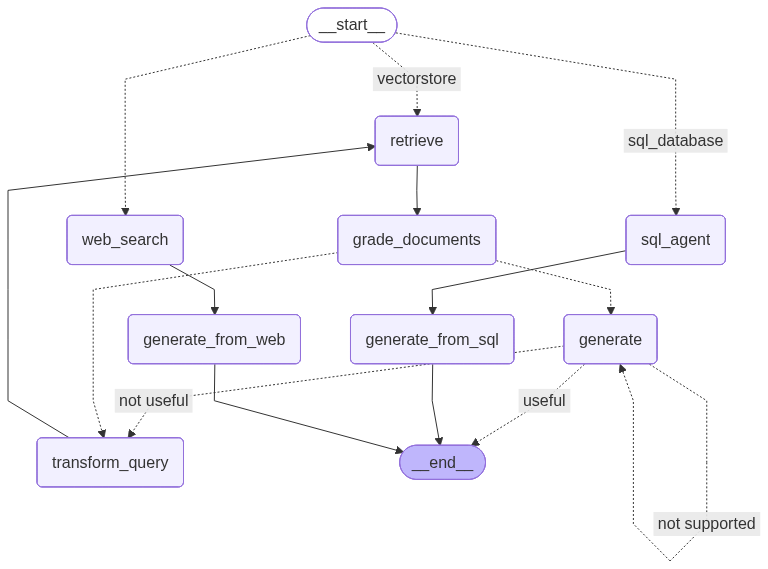

In [24]:
# =============================================================================
# Build Graph
# =============================================================================

def create_adaptive_rag():
    """Build Adaptive RAG graph with three routing paths."""
    print("\n[GRAPH] Building Adaptive RAG workflow")

    builder = StateGraph(AdaptiveRAGState)

    # Add Self-RAG nodes (imported from scripts.nodes)
    builder.add_node("retrieve", retrieve_node)
    builder.add_node("grade_documents", grade_documents_node)
    builder.add_node("generate", generate_node)
    builder.add_node("transform_query", transform_query_node)

    # Add Adaptive-specific nodes
    builder.add_node("sql_agent", sql_agent_node)
    builder.add_node("web_search", web_search_node)
    builder.add_node("generate_from_sql", generate_from_sql_node)
    builder.add_node("generate_from_web", generate_from_web_node)
    # Entry point: Route query to appropriate datasource
    builder.add_conditional_edges(
        START,
        route_question,
        {
            "vectorstore": "retrieve",
            "sql_database": "sql_agent",
            "web_search": "web_search"
        }
    )

    # Vector store path (Self-RAG flow)
    builder.add_edge("retrieve", "grade_documents")
    builder.add_conditional_edges(
        "grade_documents",
        decide_to_generate,
        {
            "transform_query": "transform_query",
            "generate": "generate"
        }
    )
    builder.add_edge("transform_query", "retrieve")  # Loop back
    builder.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_query,
        {
            "not supported": "generate",  # Regenerate
            "useful": END,
            "not useful": "transform_query"
        }
    )

    # SQL database path
    builder.add_edge("sql_agent", "generate_from_sql")
    builder.add_edge("generate_from_sql", END)

    # Web search path
    builder.add_edge("web_search", "generate_from_web")
    builder.add_edge("generate_from_web", END)

    return builder.compile()

graph = create_adaptive_rag()

graph


In [17]:
result = graph.invoke({
    "query": "What was Amazon's revenue in 2023?"
})
print(result['generation'])


[NODE] Query Analysis - Routing query
[QUERY] What was Amazon's revenue in 2023?
[ROUTE] -> vectorstore

[NODE] Retrieve - Fetching documents
[QUERY 1] What was Amazon's revenue in 2023?

[TOOL] retrieve_docs called
[QUERY] What was Amazon's revenue in 2023?
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 10: score=34.1646
  [2] Doc 4: score=33.1318
  [3] Doc 2: score=32.1640
  [4] Doc 5: score=31.9378
  [5] Doc 3: score=28.7784
[RETRIEVED] 3 documents
[RETRIEVED] Documents fetched for 1 queries

[NODE] Grade Documents - Evaluating document relevance
[GRADE] Relevance: yes

[ROUTER] Assess graded documents
[DECISION] Have relevant documents - generating answer

[NODE] Generate - Creating answer
[GENERATED] Answer created (1541 chars)

[ROUTER] Check hallucinations and answer quality
[CHECK] Hallucinations
[DECISION] Generation is grounded in documents
[CHECK] Answer quality
[DECISION] Generation addresses query - USEFUL
## Amazon's Revenue in 2023

Amazon's total revenu

In [ ]:
result = graph.invoke({
    "query": "What is the current inflation rate across the globe?"
})
print(result['generation'])


[NODE] Query Analysis - Routing query
[QUERY] What is the current inflation rate across the globe?
[ROUTE] -> web_search

[NODE] Web Search - Searching the web
[WEB RESULTS] 2301 characters retrieved

[NODE] Generate - Creating answer from web search
[GENERATED] Answer created (1798 chars)
## Current Global Inflation Rate: A Summary  

The **current global inflation rate** is a complex metric, as inflation varies significantly across countries and regions. However, **recent data from major economies** suggests a mixed global trend, with some regions experiencing cooling inflation while others face persistent price pressures.  

### Key Insights from Available Data  
- **United States**: As of late 2024, the U.S. inflation rate has declined but remains above the Federal Reserve’s target. The Consumer Price Index (CPI) showed a **3.2% annual increase in October 2024**, down from peak levels earlier in the year.  
- **European Union**: The Eurozone’s Harmonized Index of Consumer Prices (

In [26]:
result = graph.invoke({
    "query": "List top 5 highest paid employees in the Finance department"
})
print(result['generation'])


[NODE] Query Analysis - Routing query
[QUERY] List top 5 highest paid employees in the Finance department
[ROUTE] -> sql_database

[NODE] SQL Agent - Querying employee database
Getting schema for: employees
Retrieved schema for table: employees
[SQL RESULTS] The provided database schema for the "employees" table does not include columns for **department** or **salary**, which are required to answer the question. To proceed, we would need additional tables...

[NODE] Generate - Creating answer from SQL results
[GENERATED] Answer created (467 chars)
The provided schema for the `employees` table does not include columns for **department** or **salary**, which are required to answer the question. Without access to additional tables (e.g., `departments`, `salaries`) or schema clarification, it is not possible to retrieve the requested data.

**Next Steps:**
- Confirm if other tables (e.g., `departments`, `salaries`) exist and share their schema.
- Provide the necessary column names and rel

In [ ]:
result = graph.invoke({
    "query": "Compare Apple and Amazon revenue in Q1 2024"
})

print(result['generation'])


[NODE] Query Analysis - Routing query
[QUERY] Compare Apple and Google revenue in Q1 2024
[ROUTE] -> vectorstore

[NODE] Retrieve - Fetching documents
[QUERY 1] Compare Apple and Google revenue in Q1 2024

[TOOL] retrieve_docs called
[QUERY] Compare Apple and Google revenue in Q1 2024
[BM25] Ranked 5 documents by heading+content chunks
  [1] Doc 1: score=25.2225
  [2] Doc 3: score=21.6813
  [3] Doc 0: score=21.6567
  [4] Doc 4: score=18.2055
  [5] Doc 2: score=17.6058
[RETRIEVED] 3 documents
[RETRIEVED] Documents fetched for 1 queries

[NODE] Grade Documents - Evaluating document relevance
[GRADE] Relevance: no

[ROUTER] Assess graded documents
[DECISION] No relevant documents - transforming query

[NODE] Transform Query - Rewriting query
[ORIGINAL] Compare Apple and Google revenue in Q1 2024
[DECOMPOSED QUERIES] ['Apple total revenue Q1 2024', 'Google total revenue Q1 2024']

[NODE] Retrieve - Fetching documents
[QUERY 1] Apple total revenue Q1 2024

[TOOL] retrieve_docs called
[QUER